# Progetto per il corso di Cognitive Computing Systems
## Visual Recongition per la rilevazione di tumori cerebrali
**Anno accademico 2022/2023**  
Autori: Ferinando Simone D'Agostino, Simone D'Orta.  
Docente: prof. Paolo Maresca.  
[![Github repo](https://img.shields.io/static/v1?label=GitHub&message=FuseMedML&color=brightgreen)](https://github.com/BiomedSciAI/fuse-med-ml)

[![PyPI version](https://badge.fury.io/py/fuse-med-ml.svg)](https://badge.fury.io/py/fuse-med-ml)

[![Slack channel](https://img.shields.io/badge/support-slack-slack.svg?logo=slack)](https://join.slack.com/t/fusemedml/shared_invite/zt-xr1jaj29-h7IMsSc0Lq4qpVNxW97Phw)

[![Open Source](https://badges.frapsoft.com/os/v1/open-source.svg)](https://github.com/BiomedSciAI/fuse-med-ml)


------------
## **Installation Details - Google Colab**
Tramite i flag install_fuse e use_gpu è possibile installare FuseMedML nell'ambiente Google Colab e configurare il runtime con una GPU.

In [ ]:
# @title 1. Install FuseMedML

# @markdown Please choose whether or not to install FuseMedML and execute this cell by pressing the *Play* button on the left.


install_fuse = True  # @param {type:"boolean"}
use_gpu = True  # @param {type:"boolean"}

# @markdown ### **Warning!**
# @markdown If you wish to install FuseMedML -- as a workaround for
# @markdown [this](https://stackoverflow.com/questions/57831187/need-to-restart-runtime-before-import-an-installed-package-in-colab)
# @markdown issue please follow those steps:   <br>
# @markdown 1. Execute this cell by pressing the ▶️ button on the left.
# @markdown 2. Restart runtime
# @markdown 3. Execute it once again
# @markdown 4. Enjoy
if install_fuse:
    !git clone https://github.com/BiomedSciAI/fuse-med-ml.git
    %cd fuse-med-ml
    %pip install -e .[all,examples]

Cloning into 'fuse-med-ml'...
remote: Enumerating objects: 14233, done.
remote: Counting objects: 100% (2938/2938), done.
remote: Compressing objects: 100% (1532/1532), done.
remote: Total 14233 (delta 1876), reused 2275 (delta 1341), pack-reused 11295
Receiving objects: 100% (14233/14233), 106.41 MiB | 27.17 MiB/s, done.
Resolving deltas: 100% (9133/9133), done.
/content/fuse-med-ml
Obtaining file:///content/fuse-med-ml
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79


## **Setup environment**
Nel seguito si configura l'ambiente del progetto. Innazitutto, si importano le libreria necessatie (FuseMed e Pytorch).

##### **Imports**

In [ ]:
# @title 1. Imports

# @markdown Please execute this cell by pressing the *Play* button on the left.

import os
import copy
from typing import OrderedDict

import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data.dataloader import DataLoader

from fuse.eval.evaluator import EvaluatorDefault
from fuse.dl.losses.loss_default import LossDefault
from fuse.eval.metrics.classification.metrics_classification_common import MetricAccuracy, MetricAUCROC, MetricROCCurve
from fuse.eval.metrics.classification.metrics_thresholding_common import MetricApplyThresholds
from fuse.dl.models.model_wrapper import ModelWrapSeqToDict
from fuse.data.utils.samplers import BatchSamplerDefault
from fuse.data.utils.collates import CollateDefault
from fuse.dl.lightning.pl_module import LightningModuleDefault
from fuse.dl.lightning.pl_funcs import convert_predictions_to_dataframe
from fuse.utils.file_io.file_io import create_dir, save_dataframe
from fuseimg.datasets.mnist import MNIST

from fuse_examples.imaging.hello_world.hello_world_utils import LeNet, perform_softmax

from fuse.data.datasets.dataset_wrap_seq_to_dict import  DatasetWrapSeqToDict
from torchvision import transforms, datasets

##### **Data**
Si caricano i dati da Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **STRUTTURA DELLA RETE A DUE LIVELLI**
Ricordiamo che ogni campione è caratterizzato da sei immagini RMN di tipo “ADC”, "DWI", "FLAIR", "GRE", "T1W" e "MDC". Un modo efficace di riuscire ad utilizzare tutti i dati a nostra disposizione è quello di creare una rete a due livelli. Il primo livello è formato da sei reti CNN che ricevono in ingresso una delle sei immagini del campione. Il secondo livello riceve l’output del penultimo layer (logits) di ognuna delle reti del primo livello. Il classificatore del secondo livello effettuerà le predizioni finali sulla base dei valori dei logits ricevuti in input. In particolare, nel secondo livello i migliori classificatori per generare predizioni accurate, sono risultati il Random Forest e il MultiLayer Perceptron.
  
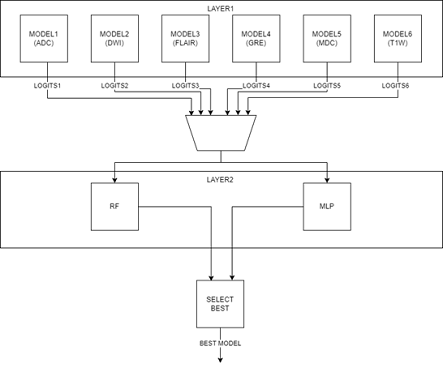

### **Livello 1**
In questo livello sono state addestrate sei reti CNN che ricevono in ingresso un tipo di immagine RMN. Per fare ciò è necessario iterare su ogni tipo di immagine utilizzando un for ed andare ad addestrare il relativo modello.

In [ ]:
categories = ['ADC', 'DWI', 'FLAIR', 'GRE', 'MDC', 'T1W']
test_result_acc = {}
predictions_training = {}
predictions_validation = {}
predictions_testing = {}
df_training = {}
df_validation = {}
df_testing = {}

for category in categories:
  ROOT = '/content/drive/MyDrive/PROGETTO_CCS'
  model_dir = os.path.join(ROOT, "MULTI/model_dir/" + category)
  PATHS = {
      "model_dir": model_dir,
      "cache_dir": os.path.join(ROOT, "MULTI/cache_dir/" + category),
      "inference_dir": os.path.join(ROOT, "MULTI/infer_dir/" + category),
      "eval_dir": os.path.join(ROOT, "MULTI/eval_dir/" + category),
  }

  paths = PATHS

  TRAIN_COMMON_PARAMS = {}

  ### Data ###
  TRAIN_COMMON_PARAMS["data.batch_size"] = 4
  TRAIN_COMMON_PARAMS["data.train_num_workers"] = 2
  TRAIN_COMMON_PARAMS["data.validation_num_workers"] = 2

  ### PL Trainer ###
  TRAIN_COMMON_PARAMS["trainer.num_epochs"] = 5
  TRAIN_COMMON_PARAMS["trainer.num_devices"] = 1
  TRAIN_COMMON_PARAMS["trainer.accelerator"] = "gpu" if use_gpu else "cpu"
  TRAIN_COMMON_PARAMS["trainer.ckpt_path"] = None  #  path to the checkpoint you wish continue the training from

  ### Optimizer ###
  TRAIN_COMMON_PARAMS["opt.lr"] = 1e-4
  TRAIN_COMMON_PARAMS["opt.weight_decay"] = 0.001

  train_params = TRAIN_COMMON_PARAMS
  ## Training Data
  # Create dataset
  data_dir = '/content/drive/MyDrive/PROGETTO_CCS/DATASET_MULTI'
  transform = transforms.Compose([
      transforms.Resize((224,224)),
      #transforms.CenterCrop(224),
      #transforms.RandomCrop(224),
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.3081,))])
      #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
  torch_train_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x),transform) for x in ['training_MULTI_' + category, 'testing_MULTI_' + category, 'validation_MULTI_' + category]}
  train_dataset = DatasetWrapSeqToDict(name='training_MULTI_' + category, dataset=torch_train_dataset['training_MULTI_' + category], sample_keys=('data.' + category + 'image', 'data.' + category + 'label'))
  train_dataset.create()

  # Create Fuse's custom sampler
  sampler = BatchSamplerDefault(
      dataset=train_dataset,
      balanced_class_name="data." + category + "label",
      num_balanced_classes=2,
      batch_size=train_params["data.batch_size"],
      balanced_class_weights=None,
  )

  # Create dataloader
  train_dataloader = DataLoader(
      dataset=train_dataset,
      batch_sampler=sampler,
      collate_fn=CollateDefault(),
      num_workers=train_params["data.train_num_workers"],
  )

  ## Validation data
  # Create dataset
  validation_dataset = DatasetWrapSeqToDict(name='validation_MULTI_' + category, dataset=torch_train_dataset['validation_MULTI_' + category], sample_keys=('data.' + category + 'image', 'data.' + category + 'label'))
  validation_dataset.create()

  # dataloader
  validation_dataloader = DataLoader(
      dataset=validation_dataset,
      batch_size=train_params["data.batch_size"],
      collate_fn=CollateDefault(),
      num_workers=train_params["data.validation_num_workers"],
  )

  ## MODEL ##
  import torchvision.models as models

  def create_model():
      torch_model = models.resnet18(pretrained=True)
      # wrap basic torch model to automatically read inputs from batch_dict and save its outputs to batch_dict
      model = ModelWrapSeqToDict(
          model=torch_model,
          model_inputs=["data." + category + "image"],
          post_forward_processing_function=perform_softmax,
          model_outputs=["model.logits." + category + "classification", "model.output." + category + "classification"],
      )
      return model
  model = create_model()

  ## loss
  losses = {
      "cls_loss": LossDefault(
          pred="model.logits." + category + "classification", target="data." + category + "label", callable=F.cross_entropy, weight=1.0
      ),
  }

  ## METRICS
  train_metrics = OrderedDict(
      [
          ("operation_point", MetricApplyThresholds(pred="model.logits." + category + "classification")),  # will apply argmax
          ("accuracy", MetricAccuracy(pred="results:metrics.operation_point.cls_pred", target="data." + category + "label")),
      ]
  )
  validation_metrics = copy.deepcopy(train_metrics)  # use the same metrics in validation as well

  best_epoch_source = dict(monitor="validation.metrics.accuracy", mode="max")

  # create optimizer
  optimizer = optim.Adam(model.parameters(), lr=train_params["opt.lr"], weight_decay=train_params["opt.weight_decay"])

  # create scheduler
  lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
  lr_sch_config = dict(scheduler=lr_scheduler, monitor="validation.losses.total_loss")

  # optimizer and lr sch - see pl.LightningModule.configure_optimizers return value for all options
  optimizers_and_lr_schs = dict(optimizer=optimizer, lr_scheduler=lr_sch_config)

  # create instance of PL module - FuseMedML generic version
  pl_module = LightningModuleDefault(
      model_dir=paths["model_dir"],
      model=model,
      losses=losses,
      train_metrics=train_metrics,
      validation_metrics=validation_metrics,
      best_epoch_source=best_epoch_source,
      optimizers_and_lr_schs=optimizers_and_lr_schs,
  )
  pl_module.set_predictions_keys(
    ["model.logits." + category + "classification","model.output." + category + "classification", "data." + category + "label"]
  )  # which keys to extract and dump into file

  # create lightning trainer
  pl_trainer = pl.Trainer(
      default_root_dir=paths["model_dir"],
      max_epochs=train_params["trainer.num_epochs"],
      accelerator=train_params["trainer.accelerator"],
      devices=train_params["trainer.num_devices"],
  )

  # train
  pl_trainer.fit(pl_module, train_dataloader, validation_dataloader, ckpt_path=train_params["trainer.ckpt_path"])
    # set the prediction keys to extract (the ones used be the evaluation function).

  train_dataloader_pred = DataLoader(dataset=train_dataset, collate_fn=CollateDefault(), batch_size=2, num_workers=2) # testing_dataloader
  validation_dataloader_pred = DataLoader(dataset=validation_dataset, collate_fn=CollateDefault(), batch_size=2, num_workers=2) # testing_dataloader
  predictions_training[category] = pl_trainer.predict(pl_module, train_dataloader_pred, return_predictions=True)
  predictions_validation[category] = pl_trainer.predict(pl_module, validation_dataloader_pred, return_predictions=True)
  # convert list of batch outputs into a dataframe
  df_training[category] = convert_predictions_to_dataframe(predictions_training[category])
  df_validation[category] = convert_predictions_to_dataframe(predictions_validation[category])


  ## INFER
  INFER_COMMON_PARAMS = {}
  INFER_COMMON_PARAMS["infer_filename"] = "infer_file.gz"
  INFER_COMMON_PARAMS["checkpoint"] = "best_epoch.ckpt"
  INFER_COMMON_PARAMS["trainer.num_devices"] = TRAIN_COMMON_PARAMS["trainer.num_devices"]
  INFER_COMMON_PARAMS["trainer.accelerator"] = TRAIN_COMMON_PARAMS["trainer.accelerator"]

  infer_common_params = INFER_COMMON_PARAMS

  # setting dir and paths
  create_dir(paths["inference_dir"])
  infer_file = os.path.join(paths["inference_dir"], infer_common_params["infer_filename"])
  checkpoint_file = os.path.join(paths["model_dir"], infer_common_params["checkpoint"])

  # creating a dataloader
  testing_dataset = DatasetWrapSeqToDict(name='testing_MULTI_' + category, dataset=torch_train_dataset['testing_MULTI_' + category], sample_keys=('data.' + category +'image', 'data.' + category + 'label'))
  testing_dataset.create()
  testing_dataloader = DataLoader(dataset=testing_dataset, collate_fn=CollateDefault(), batch_size=2, num_workers=2) # testing_dataloader

  # load pytorch lightning module
  model = create_model()
  pl_module = LightningModuleDefault.load_from_checkpoint(
      checkpoint_file, model_dir=paths["model_dir"], model=model, map_location="cpu", strict=True
  )

  # set the prediction keys to extract (the ones used be the evaluation function).
  pl_module.set_predictions_keys(
      ["model.logits." + category + "classification","model.output." + category + "classification", "data." + category + "label"]
  )  # which keys to extract and dump into file

  # create a trainer instance
  pl_trainer = pl.Trainer(
      default_root_dir=paths["model_dir"],
      accelerator=infer_common_params["trainer.accelerator"],
      devices=infer_common_params["trainer.num_devices"],
  )

  # predict
  predictions_testing[category] = pl_trainer.predict(pl_module, testing_dataloader, return_predictions=True)

  # convert list of batch outputs into a dataframe
  df_testing[category] = convert_predictions_to_dataframe(predictions_testing[category])
  save_dataframe(df_testing[category], infer_file)

  ## EVAL
  EVAL_COMMON_PARAMS = {}
  EVAL_COMMON_PARAMS["infer_filename"] = INFER_COMMON_PARAMS["infer_filename"]

  eval_common_params = EVAL_COMMON_PARAMS

  class_names = ['GBM', 'MET']

  # metrics
  metrics = OrderedDict(
      [
          ("operation_point", MetricApplyThresholds(pred="model.output." + category + "classification")),  # will apply argmax
          ("accuracy", MetricAccuracy(pred="results:metrics.operation_point.cls_pred", target="data." + category + "label")),
          (
              "roc",
              MetricROCCurve(
                  pred="model.output." + category + "classification",
                  target="data." + category + "label",
                  class_names=class_names,
                  output_filename=os.path.join(paths["inference_dir"], "roc_curve.png"),
              ),
          ),
          ("auc", MetricAUCROC(pred="model.output." + category + "classification", target="data." + category + "label", class_names=class_names)),
      ]
  )

  # create evaluator
  evaluator = EvaluatorDefault()

  # run eval
  results = evaluator.eval(
      ids=None,
      data=os.path.join(paths["inference_dir"], eval_common_params["infer_filename"]),
      metrics=metrics,
      output_dir=paths["eval_dir"],
      silent=False,
  )

  print("Done!")

  test_result_acc[category] = results["metrics.accuracy"]

multiprocess pool created with 10 workers.


batch_sampler: 100%|██████████| 225/225 [00:10<00:00, 20.53it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TP

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Stats for epoch: 0 (Currently the best epoch for source validation.metrics.accuracy!)

------------------------------------------------------------------------------------------
|                             | Best Epoch (0)              | Current Epoch (0)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 3.3532                      | 3.3532                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 3.3532                      | 3.3532                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.6250                      | 0.6250                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.5029                      | 1.5029                      

Validation: 0it [00:00, ?it/s]

Stats for epoch: 1 (Currently the best epoch for source validation.metrics.accuracy!)

------------------------------------------------------------------------------------------
|                             | Best Epoch (1)              | Current Epoch (1)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.3242                      | 0.3242                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.3242                      | 0.3242                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9356                      | 0.9356                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5917                      | 0.5917                      

Validation: 0it [00:00, ?it/s]

Stats for epoch: 2 (Currently the best epoch for source validation.metrics.accuracy!)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (2)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0375                      | 0.0375                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0375                      | 0.0375                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6005                      | 0.6005                      

Validation: 0it [00:00, ?it/s]

Stats for epoch: 3 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (3)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0375                      | 0.0462                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0375                      | 0.0462                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 0.9848                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6005                      | 1.4286                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 4 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (4)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0375                      | 0.0855                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0375                      | 0.0855                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 0.9886                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6005                      | 0.4896                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 5 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (5)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0375                      | 0.0060                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0375                      | 0.0060                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6005                      | 0.6831                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 6 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (6)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0375                      | 0.0026                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0375                      | 0.0026                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6005                      | 0.5922                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 7 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (7)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0375                      | 0.0026                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0375                      | 0.0026                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6005                      | 0.8214                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 8 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (8)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0375                      | 0.0021                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0375                      | 0.0021                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6005                      | 0.7219                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 9 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (9)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0375                      | 0.0018                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0375                      | 0.0018                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6005                      | 0.7986                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 10 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (10)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0375                      | 0.0015                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0375                      | 0.0015                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6005                      | 0.6788                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 11 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (11)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0375                      | 0.0021                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0375                      | 0.0021                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6005                      | 0.6977                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 12 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (12)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0375                      | 0.0015                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0375                      | 0.0015                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6005                      | 0.7243                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 13 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (13)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0375                      | 0.0021                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0375                      | 0.0021                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6005                      | 0.6556                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 14 (Currently the best epoch for source validation.metrics.accuracy!)

------------------------------------------------------------------------------------------
|                             | Best Epoch (14)             | Current Epoch (14)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0013                      | 0.0013                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0013                      | 0.0013                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6531                      | 0.6531                     

Validation: 0it [00:00, ?it/s]

Stats for epoch: 15 (Best epoch is 14 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (14)             | Current Epoch (15)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0013                      | 0.0013                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0013                      | 0.0013                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6531                      | 0.7070                      |
------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 16 (Best epoch is 14 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (14)             | Current Epoch (16)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0013                      | 0.0011                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0013                      | 0.0011                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6531                      | 0.6840                      |
------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 17 (Best epoch is 14 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (14)             | Current Epoch (17)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0013                      | 0.0011                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0013                      | 0.0011                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6531                      | 0.6943                      |
------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 18 (Best epoch is 14 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (14)             | Current Epoch (18)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0013                      | 0.0016                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0013                      | 0.0016                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6531                      | 0.6911                      |
------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 19 (Best epoch is 14 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (14)             | Current Epoch (19)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0013                      | 0.0011                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0013                      | 0.0011                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6531                      | 0.7094                      |
------

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: LearningRateMonitor, ModelCheckpoint, ModelEpochSummary
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: LearningRateMonitor, ModelCheckpoint, ModelEpochSummary
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:The follow

Predicting: 0it [00:00, ?it/s]

Results:

Metric operation_point.cls_pred:
------------------------------------------------

Metric accuracy:
------------------------------------------------
0.8333333333333334

Metric roc.GBM.fpr:
------------------------------------------------
[0.         0.         0.         0.08333333 0.08333333 0.16666667
 0.16666667 0.25       0.25       0.33333333 0.33333333 1.        ]

Metric roc.GBM.tpr:
------------------------------------------------
[0.         0.05555556 0.22222222 0.22222222 0.83333333 0.83333333
 0.88888889 0.88888889 0.94444444 0.94444444 1.         1.        ]

Metric roc.GBM.auc:
------------------------------------------------
0.9074074074074074

Metric roc.MET.fpr:
------------------------------------------------
[0.         0.         0.         0.05555556 0.05555556 0.16666667
 0.16666667 0.77777778 0.77777778 1.        ]

Metric roc.MET.tpr:
------------------------------------------------
[0.         0.08333333 0.66666667 0.66666667 0.83333333 0.83333333
 0.

batch_sampler: 100%|██████████| 225/225 [00:07<00:00, 30.57it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, us

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Stats for epoch: 0 (Currently the best epoch for source validation.metrics.accuracy!)

------------------------------------------------------------------------------------------
|                             | Best Epoch (0)              | Current Epoch (0)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 3.3965                      | 3.3965                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 3.3965                      | 3.3965                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.6023                      | 0.6023                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.4475                      | 1.4475                      

Validation: 0it [00:00, ?it/s]

Stats for epoch: 1 (Best epoch is 0 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (0)              | Current Epoch (1)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 3.3965                      | 0.3912                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 3.3965                      | 0.3912                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.6023                      | 0.9280                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.4475                      | 1.4987                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 2 (Currently the best epoch for source validation.metrics.accuracy!)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (2)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.1076                      | 0.1076                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.1076                      | 0.1076                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9697                      | 0.9697                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6738                      | 0.6738                      

Validation: 0it [00:00, ?it/s]

Stats for epoch: 3 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (3)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.1076                      | 0.0305                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.1076                      | 0.0305                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9697                      | 0.9962                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6738                      | 0.7428                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 4 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (4)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.1076                      | 0.0191                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.1076                      | 0.0191                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9697                      | 0.9962                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6738                      | 1.3396                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 5 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (5)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.1076                      | 0.0101                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.1076                      | 0.0101                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9697                      | 0.9962                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6738                      | 1.2181                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 6 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (6)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.1076                      | 0.0029                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.1076                      | 0.0029                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9697                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6738                      | 1.1177                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 7 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (7)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.1076                      | 0.0028                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.1076                      | 0.0028                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9697                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6738                      | 0.9262                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 8 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (8)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.1076                      | 0.0024                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.1076                      | 0.0024                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9697                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6738                      | 1.0713                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 9 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (9)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.1076                      | 0.0025                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.1076                      | 0.0025                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9697                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6738                      | 1.1145                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 10 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (10)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.1076                      | 0.0020                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.1076                      | 0.0020                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9697                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6738                      | 1.1074                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 11 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (11)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.1076                      | 0.0017                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.1076                      | 0.0017                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9697                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6738                      | 1.0513                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 12 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (12)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.1076                      | 0.0024                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.1076                      | 0.0024                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9697                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6738                      | 1.1084                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 13 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (13)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.1076                      | 0.0015                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.1076                      | 0.0015                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9697                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6738                      | 1.2044                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 14 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (14)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.1076                      | 0.0017                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.1076                      | 0.0017                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9697                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6738                      | 1.1090                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 15 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (15)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.1076                      | 0.0018                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.1076                      | 0.0018                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9697                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6738                      | 1.2632                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 16 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (16)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.1076                      | 0.0025                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.1076                      | 0.0025                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9697                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6738                      | 1.1471                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 17 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (17)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.1076                      | 0.0015                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.1076                      | 0.0015                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9697                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6738                      | 1.1139                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 18 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (18)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.1076                      | 0.0017                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.1076                      | 0.0017                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9697                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6738                      | 1.2069                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 19 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (19)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.1076                      | 0.0015                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.1076                      | 0.0015                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9697                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.6738                      | 1.0904                      |
-------

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: LearningRateMonitor, ModelCheckpoint, ModelEpochSummary
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: LearningRateMonitor, ModelCheckpoint, ModelEpochSummary
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:The follow

Predicting: 0it [00:00, ?it/s]

Results:

Metric operation_point.cls_pred:
------------------------------------------------

Metric accuracy:
------------------------------------------------
0.8333333333333334

Metric roc.GBM.fpr:
------------------------------------------------
[0.         0.         0.         0.08333333 0.08333333 0.25
 0.25       0.33333333 0.33333333 0.41666667 0.41666667 1.        ]

Metric roc.GBM.tpr:
------------------------------------------------
[0.         0.05555556 0.22222222 0.22222222 0.27777778 0.27777778
 0.38888889 0.38888889 0.88888889 0.88888889 1.         1.        ]

Metric roc.GBM.auc:
------------------------------------------------
0.7546296296296295

Metric roc.MET.fpr:
------------------------------------------------
[0.         0.         0.         0.11111111 0.11111111 0.44444444
 0.44444444 0.66666667 0.66666667 0.72222222 0.72222222 0.77777778
 0.77777778 1.        ]

Metric roc.MET.tpr:
------------------------------------------------
[0.         0.08333333 0.583333

batch_sampler: 100%|██████████| 225/225 [00:10<00:00, 22.30it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, us

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Stats for epoch: 0 (Currently the best epoch for source validation.metrics.accuracy!)

------------------------------------------------------------------------------------------
|                             | Best Epoch (0)              | Current Epoch (0)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 3.6460                      | 3.6460                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 3.6460                      | 3.6460                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.5492                      | 0.5492                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 2.8977                      | 2.8977                      

Validation: 0it [00:00, ?it/s]

Stats for epoch: 1 (Currently the best epoch for source validation.metrics.accuracy!)

------------------------------------------------------------------------------------------
|                             | Best Epoch (1)              | Current Epoch (1)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.2499                      | 0.2499                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.2499                      | 0.2499                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9583                      | 0.9583                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.1756                      | 1.1756                      

Validation: 0it [00:00, ?it/s]

Stats for epoch: 2 (Best epoch is 1 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (1)              | Current Epoch (2)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.2499                      | 0.0201                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.2499                      | 0.0201                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9583                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.1756                      | 1.2120                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 3 (Best epoch is 1 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (1)              | Current Epoch (3)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.2499                      | 0.0127                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.2499                      | 0.0127                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9583                      | 0.9962                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.1756                      | 1.3213                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 4 (Best epoch is 1 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (1)              | Current Epoch (4)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.2499                      | 0.0141                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.2499                      | 0.0141                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9583                      | 0.9962                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.1756                      | 1.4338                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 5 (Best epoch is 1 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (1)              | Current Epoch (5)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.2499                      | 0.0069                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.2499                      | 0.0069                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9583                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.1756                      | 1.3698                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 6 (Currently the best epoch for source validation.metrics.accuracy!)

------------------------------------------------------------------------------------------
|                             | Best Epoch (6)              | Current Epoch (6)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0757                      | 0.0757                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0757                      | 0.0757                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9848                      | 0.9848                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.9312                      | 0.9312                      

Validation: 0it [00:00, ?it/s]

Stats for epoch: 7 (Currently the best epoch for source validation.metrics.accuracy!)

------------------------------------------------------------------------------------------
|                             | Best Epoch (7)              | Current Epoch (7)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0716                      | 0.0716                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0716                      | 0.0716                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 0.9924                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.7574                      | 0.7574                      

Validation: 0it [00:00, ?it/s]

Stats for epoch: 8 (Best epoch is 7 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (7)              | Current Epoch (8)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0716                      | 0.0823                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0716                      | 0.0823                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 0.9697                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.7574                      | 1.0457                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 9 (Best epoch is 7 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (7)              | Current Epoch (9)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0716                      | 0.0197                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0716                      | 0.0197                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 0.9924                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.7574                      | 1.9292                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 10 (Best epoch is 7 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (7)              | Current Epoch (10)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0716                      | 0.0285                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0716                      | 0.0285                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 0.9924                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.7574                      | 2.7845                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 11 (Best epoch is 7 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (7)              | Current Epoch (11)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0716                      | 0.1124                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0716                      | 0.1124                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 0.9773                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.7574                      | 1.3022                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 12 (Best epoch is 7 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (7)              | Current Epoch (12)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0716                      | 0.0094                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0716                      | 0.0094                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.7574                      | 1.1440                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 13 (Best epoch is 7 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (7)              | Current Epoch (13)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0716                      | 0.0028                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0716                      | 0.0028                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.7574                      | 1.1531                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 14 (Best epoch is 7 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (7)              | Current Epoch (14)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0716                      | 0.0022                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0716                      | 0.0022                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.7574                      | 1.1682                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 15 (Best epoch is 7 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (7)              | Current Epoch (15)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0716                      | 0.0011                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0716                      | 0.0011                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.7574                      | 1.1800                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 16 (Best epoch is 7 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (7)              | Current Epoch (16)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0716                      | 0.0019                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0716                      | 0.0019                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.7574                      | 1.2305                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 17 (Best epoch is 7 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (7)              | Current Epoch (17)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0716                      | 0.0010                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0716                      | 0.0010                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.7574                      | 1.2420                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 18 (Best epoch is 7 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (7)              | Current Epoch (18)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0716                      | 0.0007                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0716                      | 0.0007                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.7574                      | 1.1599                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 19 (Best epoch is 7 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (7)              | Current Epoch (19)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0716                      | 0.0009                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0716                      | 0.0009                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.7574                      | 1.2657                      |
-------

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: LearningRateMonitor, ModelCheckpoint, ModelEpochSummary
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: LearningRateMonitor, ModelCheckpoint, ModelEpochSummary
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:The follow

Predicting: 0it [00:00, ?it/s]

Results:

Metric operation_point.cls_pred:
------------------------------------------------

Metric accuracy:
------------------------------------------------
0.7666666666666667

Metric roc.GBM.fpr:
------------------------------------------------
[0.         0.         0.         0.08333333 0.08333333 0.16666667
 0.16666667 0.25       0.25       0.33333333 0.33333333 0.5
 0.5        0.66666667 0.66666667 1.        ]

Metric roc.GBM.tpr:
------------------------------------------------
[0.         0.05555556 0.22222222 0.22222222 0.66666667 0.66666667
 0.72222222 0.72222222 0.77777778 0.77777778 0.88888889 0.88888889
 0.94444444 0.94444444 1.         1.        ]

Metric roc.GBM.auc:
------------------------------------------------
0.8379629629629629

Metric roc.MET.fpr:
------------------------------------------------
[0.         0.05555556 0.05555556 0.11111111 0.11111111 0.22222222
 0.22222222 0.33333333 0.33333333 0.55555556 0.55555556 1.        ]

Metric roc.MET.tpr:
--------------

batch_sampler: 100%|██████████| 225/225 [00:07<00:00, 31.99it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, us

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Stats for epoch: 0 (Currently the best epoch for source validation.metrics.accuracy!)

------------------------------------------------------------------------------------------
|                             | Best Epoch (0)              | Current Epoch (0)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 3.7278                      | 3.7278                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 3.7278                      | 3.7278                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.5568                      | 0.5568                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.6339                      | 1.6339                      

Validation: 0it [00:00, ?it/s]

Stats for epoch: 1 (Best epoch is 0 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (0)              | Current Epoch (1)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 3.7278                      | 0.3019                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 3.7278                      | 0.3019                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.5568                      | 0.9432                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.6339                      | 1.1252                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 2 (Best epoch is 0 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (0)              | Current Epoch (2)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 3.7278                      | 0.1310                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 3.7278                      | 0.1310                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.5568                      | 0.9621                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.6339                      | 1.1607                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 3 (Best epoch is 0 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (0)              | Current Epoch (3)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 3.7278                      | 0.1042                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 3.7278                      | 0.1042                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.5568                      | 0.9773                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.6339                      | 1.7473                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 4 (Currently the best epoch for source validation.metrics.accuracy!)

------------------------------------------------------------------------------------------
|                             | Best Epoch (4)              | Current Epoch (4)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0568                      | 0.0568                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0568                      | 0.0568                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9848                      | 0.9848                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5964                      | 0.5964                      

Validation: 0it [00:00, ?it/s]

Stats for epoch: 5 (Best epoch is 4 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (4)              | Current Epoch (5)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0568                      | 0.0125                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0568                      | 0.0125                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9848                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5964                      | 0.8870                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 6 (Best epoch is 4 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (4)              | Current Epoch (6)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0568                      | 0.0034                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0568                      | 0.0034                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9848                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5964                      | 0.9052                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 7 (Best epoch is 4 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (4)              | Current Epoch (7)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0568                      | 0.0040                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0568                      | 0.0040                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9848                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5964                      | 0.7014                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 8 (Best epoch is 4 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (4)              | Current Epoch (8)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0568                      | 0.0026                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0568                      | 0.0026                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9848                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5964                      | 0.7326                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 9 (Best epoch is 4 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (4)              | Current Epoch (9)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0568                      | 0.0022                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0568                      | 0.0022                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9848                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5964                      | 0.8236                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 10 (Best epoch is 4 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (4)              | Current Epoch (10)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0568                      | 0.0021                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0568                      | 0.0021                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9848                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5964                      | 0.6985                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 11 (Best epoch is 4 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (4)              | Current Epoch (11)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0568                      | 0.0020                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0568                      | 0.0020                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9848                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5964                      | 0.7565                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 12 (Best epoch is 4 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (4)              | Current Epoch (12)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0568                      | 0.0017                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0568                      | 0.0017                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9848                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5964                      | 0.7472                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 13 (Best epoch is 4 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (4)              | Current Epoch (13)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0568                      | 0.0016                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0568                      | 0.0016                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9848                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5964                      | 0.8229                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 14 (Best epoch is 4 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (4)              | Current Epoch (14)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0568                      | 0.0021                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0568                      | 0.0021                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9848                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5964                      | 0.8714                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 15 (Best epoch is 4 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (4)              | Current Epoch (15)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0568                      | 0.0014                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0568                      | 0.0014                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9848                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5964                      | 0.8685                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 16 (Best epoch is 4 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (4)              | Current Epoch (16)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0568                      | 0.0013                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0568                      | 0.0013                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9848                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5964                      | 0.8827                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 17 (Best epoch is 4 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (4)              | Current Epoch (17)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0568                      | 0.0012                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0568                      | 0.0012                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9848                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5964                      | 0.8082                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 18 (Best epoch is 4 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (4)              | Current Epoch (18)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0568                      | 0.0018                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0568                      | 0.0018                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9848                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5964                      | 0.9189                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 19 (Best epoch is 4 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (4)              | Current Epoch (19)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0568                      | 0.0013                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0568                      | 0.0013                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9848                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5964                      | 0.8873                      |
-------

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: LearningRateMonitor, ModelCheckpoint, ModelEpochSummary
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: LearningRateMonitor, ModelCheckpoint, ModelEpochSummary
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:The follow

Predicting: 0it [00:00, ?it/s]

Results:

Metric operation_point.cls_pred:
------------------------------------------------

Metric accuracy:
------------------------------------------------
0.8

Metric roc.GBM.fpr:
------------------------------------------------
[0.         0.         0.08333333 0.08333333 0.16666667 0.16666667
 0.33333333 0.33333333 0.58333333 0.58333333 1.        ]

Metric roc.GBM.tpr:
------------------------------------------------
[0.         0.05555556 0.05555556 0.72222222 0.72222222 0.88888889
 0.88888889 0.94444444 0.94444444 1.         1.        ]

Metric roc.GBM.auc:
------------------------------------------------
0.8657407407407407

Metric roc.MET.fpr:
------------------------------------------------
[0.         0.         0.         0.05555556 0.05555556 0.16666667
 0.16666667 0.27777778 0.27777778 0.44444444 0.44444444 1.        ]

Metric roc.MET.tpr:
------------------------------------------------
[0.         0.08333333 0.41666667 0.41666667 0.75       0.75
 0.83333333 0.83333333 0

batch_sampler: 100%|██████████| 225/225 [00:06<00:00, 34.43it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, us

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Stats for epoch: 0 (Currently the best epoch for source validation.metrics.accuracy!)

------------------------------------------------------------------------------------------
|                             | Best Epoch (0)              | Current Epoch (0)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 3.6008                      | 3.6008                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 3.6008                      | 3.6008                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.5909                      | 0.5909                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 2.0142                      | 2.0142                      

Validation: 0it [00:00, ?it/s]

Stats for epoch: 1 (Currently the best epoch for source validation.metrics.accuracy!)

------------------------------------------------------------------------------------------
|                             | Best Epoch (1)              | Current Epoch (1)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.1451                      | 0.1451                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.1451                      | 0.1451                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9773                      | 0.9773                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.3914                      | 1.3914                      

Validation: 0it [00:00, ?it/s]

Stats for epoch: 2 (Currently the best epoch for source validation.metrics.accuracy!)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (2)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0273                      | 0.0273                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0273                      | 0.0273                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 0.9924                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.2404                      | 1.2404                      

Validation: 0it [00:00, ?it/s]

Stats for epoch: 3 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (3)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0273                      | 0.1399                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0273                      | 0.1399                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 0.9659                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.2404                      | 1.5060                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 4 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (4)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0273                      | 0.1176                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0273                      | 0.1176                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 0.9545                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.2404                      | 3.0154                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 5 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (5)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0273                      | 0.0157                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0273                      | 0.0157                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 0.9962                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.2404                      | 1.6927                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 6 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (6)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0273                      | 0.0035                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0273                      | 0.0035                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.2404                      | 1.7050                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 7 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (7)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0273                      | 0.0024                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0273                      | 0.0024                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.2404                      | 1.5905                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 8 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (8)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0273                      | 0.0018                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0273                      | 0.0018                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.2404                      | 1.6390                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 9 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (9)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0273                      | 0.0021                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0273                      | 0.0021                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.2404                      | 1.7305                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 10 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (10)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0273                      | 0.0017                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0273                      | 0.0017                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.2404                      | 1.6902                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 11 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (11)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0273                      | 0.0013                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0273                      | 0.0013                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.2404                      | 1.6803                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 12 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (12)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0273                      | 0.0012                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0273                      | 0.0012                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.2404                      | 1.7007                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 13 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (13)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0273                      | 0.0014                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0273                      | 0.0014                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.2404                      | 1.7014                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 14 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (14)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0273                      | 0.0012                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0273                      | 0.0012                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.2404                      | 1.6633                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 15 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (15)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0273                      | 0.0013                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0273                      | 0.0013                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.2404                      | 1.7092                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 16 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (16)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0273                      | 0.0013                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0273                      | 0.0013                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.2404                      | 1.6358                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 17 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (17)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0273                      | 0.0012                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0273                      | 0.0012                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.2404                      | 1.7013                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 18 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (18)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0273                      | 0.0012                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0273                      | 0.0012                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.2404                      | 1.7200                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 19 (Best epoch is 2 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (2)              | Current Epoch (19)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0273                      | 0.0012                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0273                      | 0.0012                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9924                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.2404                      | 1.7263                      |
-------

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: LearningRateMonitor, ModelCheckpoint, ModelEpochSummary
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: LearningRateMonitor, ModelCheckpoint, ModelEpochSummary
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:The follow

Predicting: 0it [00:00, ?it/s]

Results:

Metric operation_point.cls_pred:
------------------------------------------------

Metric accuracy:
------------------------------------------------
0.6666666666666666

Metric roc.GBM.fpr:
------------------------------------------------
[0.         0.         0.         0.08333333 0.08333333 0.16666667
 0.16666667 0.33333333 0.33333333 0.5        0.5        0.75
 0.75       1.        ]

Metric roc.GBM.tpr:
------------------------------------------------
[0.         0.05555556 0.61111111 0.61111111 0.72222222 0.72222222
 0.83333333 0.83333333 0.88888889 0.88888889 0.94444444 0.94444444
 1.         1.        ]

Metric roc.GBM.auc:
------------------------------------------------
0.8842592592592593

Metric roc.MET.fpr:
------------------------------------------------
[0.         0.         0.         0.05555556 0.05555556 0.33333333
 0.33333333 1.        ]

Metric roc.MET.tpr:
------------------------------------------------
[0.         0.08333333 0.16666667 0.16666667 0.75   

batch_sampler: 100%|██████████| 225/225 [00:09<00:00, 22.51it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, us

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Stats for epoch: 0 (Currently the best epoch for source validation.metrics.accuracy!)

------------------------------------------------------------------------------------------
|                             | Best Epoch (0)              | Current Epoch (0)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 3.4749                      | 3.4749                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 3.4749                      | 3.4749                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.5568                      | 0.5568                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 1.2388                      | 1.2388                      

Validation: 0it [00:00, ?it/s]

Stats for epoch: 1 (Currently the best epoch for source validation.metrics.accuracy!)

------------------------------------------------------------------------------------------
|                             | Best Epoch (1)              | Current Epoch (1)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.3100                      | 0.3100                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.3100                      | 0.3100                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9280                      | 0.9280                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.8229                      | 0.8229                      

Validation: 0it [00:00, ?it/s]

Stats for epoch: 2 (Best epoch is 1 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (1)              | Current Epoch (2)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.3100                      | 0.0345                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.3100                      | 0.0345                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9280                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.8229                      | 0.6265                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 3 (Best epoch is 1 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (1)              | Current Epoch (3)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.3100                      | 0.0123                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.3100                      | 0.0123                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9280                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.8229                      | 0.7502                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 4 (Best epoch is 1 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (1)              | Current Epoch (4)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.3100                      | 0.0106                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.3100                      | 0.0106                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 0.9280                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.8229                      | 0.9740                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 5 (Currently the best epoch for source validation.metrics.accuracy!)

------------------------------------------------------------------------------------------
|                             | Best Epoch (5)              | Current Epoch (5)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0034                      | 0.0034                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0034                      | 0.0034                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.7680                      | 0.7680                      

Validation: 0it [00:00, ?it/s]

Stats for epoch: 6 (Best epoch is 5 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (5)              | Current Epoch (6)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0034                      | 0.0031                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0034                      | 0.0031                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.7680                      | 0.6475                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 7 (Best epoch is 5 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (5)              | Current Epoch (7)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0034                      | 0.0028                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0034                      | 0.0028                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.7680                      | 0.8247                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 8 (Currently the best epoch for source validation.metrics.accuracy!)

------------------------------------------------------------------------------------------
|                             | Best Epoch (8)              | Current Epoch (8)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0022                      | 0.0022                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0022                      | 0.0022                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5991                      | 0.5991                      

Validation: 0it [00:00, ?it/s]

Stats for epoch: 9 (Best epoch is 8 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (8)              | Current Epoch (9)           |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0022                      | 0.0019                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0022                      | 0.0019                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5991                      | 0.7447                      |
--------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 10 (Best epoch is 8 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (8)              | Current Epoch (10)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0022                      | 0.0017                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0022                      | 0.0017                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5991                      | 0.8097                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 11 (Best epoch is 8 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (8)              | Current Epoch (11)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0022                      | 0.0019                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0022                      | 0.0019                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5991                      | 0.8183                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 12 (Best epoch is 8 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (8)              | Current Epoch (12)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0022                      | 0.0015                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0022                      | 0.0015                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5991                      | 0.8477                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 13 (Best epoch is 8 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (8)              | Current Epoch (13)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0022                      | 0.0015                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0022                      | 0.0015                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5991                      | 0.9078                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 14 (Best epoch is 8 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (8)              | Current Epoch (14)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0022                      | 0.0015                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0022                      | 0.0015                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5991                      | 0.9072                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 15 (Best epoch is 8 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (8)              | Current Epoch (15)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0022                      | 0.0011                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0022                      | 0.0011                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5991                      | 0.9849                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 16 (Best epoch is 8 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (8)              | Current Epoch (16)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0022                      | 0.0013                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0022                      | 0.0013                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5991                      | 1.0084                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 17 (Best epoch is 8 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (8)              | Current Epoch (17)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0022                      | 0.0011                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0022                      | 0.0011                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5991                      | 1.0452                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 18 (Best epoch is 8 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (8)              | Current Epoch (18)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0022                      | 0.0009                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0022                      | 0.0009                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5991                      | 1.0677                      |
-------

Validation: 0it [00:00, ?it/s]

Stats for epoch: 19 (Best epoch is 8 for source validation.metrics.accuracy)

------------------------------------------------------------------------------------------
|                             | Best Epoch (8)              | Current Epoch (19)          |
------------------------------------------------------------------------------------------
| train.losses.cls_loss       | 0.0022                      | 0.0007                      |
------------------------------------------------------------------------------------------
| train.losses.total_loss     | 0.0022                      | 0.0007                      |
------------------------------------------------------------------------------------------
| train.metrics.accuracy      | 1.0000                      | 1.0000                      |
------------------------------------------------------------------------------------------
| validation.losses.cls_loss  | 0.5991                      | 1.1942                      |
-------

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: LearningRateMonitor, ModelCheckpoint, ModelEpochSummary
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: LearningRateMonitor, ModelCheckpoint, ModelEpochSummary
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:The follow

Predicting: 0it [00:00, ?it/s]

Results:

Metric operation_point.cls_pred:
------------------------------------------------

Metric accuracy:
------------------------------------------------
0.7333333333333333

Metric roc.GBM.fpr:
------------------------------------------------
[0.         0.         0.         0.08333333 0.08333333 0.25
 0.25       0.41666667 0.41666667 0.5        0.5        1.        ]

Metric roc.GBM.tpr:
------------------------------------------------
[0.         0.05555556 0.11111111 0.11111111 0.66666667 0.66666667
 0.77777778 0.77777778 0.94444444 0.94444444 1.         1.        ]

Metric roc.GBM.auc:
------------------------------------------------
0.8287037037037037

Metric roc.MET.fpr:
------------------------------------------------
[0.         0.         0.         0.11111111 0.11111111 0.16666667
 0.16666667 0.22222222 0.22222222 0.33333333 0.33333333 0.5
 0.5        1.        ]

Metric roc.MET.tpr:
------------------------------------------------
[0.         0.08333333 0.41666667 0.41

Si creano i dataset di training, validation e testing per il secondo livello a partire dai logits estratti dal primo livello.

In [ ]:
import pandas as pd
  # Crea una lista con i nomi delle categorie
categories = ['ADC', 'DWI', 'FLAIR', 'GRE', 'MDC', 'T1W']
lista = [df_training, df_testing, df_validation]
lista_output = []
lista_logits = []

for dataframe in lista:

  # Supponiamo che tu abbia i 6 dataframe separati per categoria
  df_adc = dataframe['ADC']  # DataFrame per la categoria ADC
  df_dwi = dataframe['DWI']  # DataFrame per la categoria DWI
  df_flair = dataframe['FLAIR']  # DataFrame per la categoria FLAIR
  df_gre = dataframe['GRE']  # DataFrame per la categoria GRE
  df_mdc = dataframe['MDC']  # DataFrame per la categoria MDC
  df_t1w = dataframe['T1W']  # DataFrame per la categoria T1W

  # Crea una lista vuota per le colonne del nuovo dataframe
  columns = ['id']

  # Aggiungi le colonne desiderate al nuovo dataframe
  for category in categories:
      columns.append(f'{category} Prob0')
      columns.append(f'{category} Prob1')

  columns.append('data.label')

  # Crea un nuovo dataframe con le colonne desiderate
  df_out = pd.DataFrame(columns=columns)

  columns_logits = ['id']
  for category in categories:
    for i in range(len(dataframe[category])):
      columns_logits.append(f"{category}{i}")
  columns_logits.append('data.label')
  df_logits = pd.DataFrame(columns=columns_logits)

  # Itera sulle righe del primo dataframe (usiamo df_adc come esempio)
  for index, row in df_adc.iterrows():
      # Estrai l'id del dataframe
      id_value = row['id']
      df_out.at[index, 'id'] = id_value
      df_logits.at[index, 'id'] = id_value

      label_value = row[f'data.ADClabel']
      df_out.at[index, 'data.label'] = label_value
      df_logits.at[index, 'data.label'] = label_value

  # Aggiungi i valori delle colonne desiderate dai dataframe per ogni categoria
  for category in categories:
      # Estrai i valori dalla colonna 'model.output.{CATEGORIA}classification'
      for index, row in dataframe[category].iterrows():
        classification_list = row[f'model.output.{category}classification']
        first_value = classification_list[0]
        second_value = classification_list[1]
        df_out.at[index, f'{category} Prob0'] = first_value
        df_out.at[index, f'{category} Prob1'] = second_value
  df_out['data.label'] = pd.to_numeric(df_out['data.label'], errors='coerce') # trasforma label in numerico
  lista_output.append(df_out)


  # logits
  for category in categories:
    for index, row in dataframe[category].iterrows():
      logits_list = row[f'model.logits.{category}classification']
      for i in range(len(logits_list)):
        df_logits.at[index,f'{category}{i}'] = logits_list[i]
  df_logits['data.label'] = pd.to_numeric(df_out['data.label'], errors='coerce') # trasforma label in numerico
  df_logits = df_logits.copy()
  lista_logits.append(df_logits)

df_training_output = lista_output[0]
df_testing_output = lista_output[1]
df_validation_output = lista_output[2]

df_training_logits = lista_logits[0]
df_testing_logits = lista_logits[1]
df_validation_logits = lista_logits[2]


### **Livello 2**
Nel secondo livello è addestrato un classificatore in grado di ricevere in input tutti e sei i logits del livello precedente e generare in output una predizione. In particolare, i due migliori classificatori sono risultati il Random Forest ed il MultiLayer Perceptron (MLP). Per ognuno dei due classificatori nel secondo livello si testano diverse configurazioni di iperparametri e si salvano i risultati.  
  
Di seguito il Random Forest.

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pickle
import os
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Seleziona le colonne features
features = df_training_logits.columns[1:-1]  # Escludi la colonna 'id' e 'data.label'
# Seleziona la colonna target
target = 'data.label'
train_df, test_df, valid_df, train_labels, test_labels, valid_labels = [df_training_logits[features], df_testing_logits[features], df_validation_logits[features], df_training_logits[target], df_testing_logits[target], df_validation_logits[target]]

# Iperparametri
n_estimators = [50, 100, 500, 1000]
max_depth = [None, 10, 20]
# Valori migliori da salvare
best_accuracy = 0
best_model = None
best_estimator = 0
best_depth = None

# Ciclo su tutti gli iperparametri per trovare la migliore combinazione e salvarla
for estimator in n_estimators:
    for depth in max_depth:
        # Crea il modello di Random Forest
        random_forest = RandomForestClassifier(n_estimators=estimator, max_depth=depth)
        # Addestra il modello sul training set
        random_forest.fit(train_df, train_labels)
        # Effettua la predizione sul test set
        predictions = random_forest.predict(valid_df)
        # Valuta l'accuratezza del modello
        accuracy = accuracy_score(valid_labels, predictions)
        # Salva solo il modello con l'accuratezza più alta
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = random_forest
            best_estimator = estimator
            best_depth = depth

# Salva il modello con l'accuratezza più alta
model_random_forest_path = os.path.join(ROOT, "MULTI/RandomForest/random_forest_model.pkl")
with open(model_random_forest_path, 'wb') as file:
    pickle.dump(best_model, file)

# Effettua la predizione sul dataset di test utilizzando il modello migliore
predictions = best_model.predict(test_df)
# Salva le predizioni
predictions_path = os.path.join(ROOT, "MULTI/RandomForest/predictions.npy")
np.save(predictions_path, predictions)
# Calcola le metriche associate al modello migliore
accuracy = accuracy_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)

# Salva le metriche
metrics_path = os.path.join(ROOT, "MULTI/RandomForest/metrics.txt")
with open(metrics_path, 'w') as file:
    file.write(f'Accuracy: {accuracy}\n')
    file.write(f'Recall: {recall}\n')
    file.write(f'Precision: {precision}\n')
    file.write(f'F1-score: {f1}\n')
    file.write('\nParametri migliori:\n')
    file.write(f'Estimator: {best_estimator}\n')
    file.write(f'Max depth: {best_depth}\n')


Di seguito il MultiLayer Perceptron.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pickle
import os
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Iperparametri
hidden_layer_sizes = [(50,), (100,), (50, 50), (100, 100)]
activations = ['relu', 'logistic', 'tanh', 'identity']
solvers = ['adam', 'sgd', 'lbfgs']

best_accuracy = 0
best_model = None
best_hidden_size = (50,)
best_activation = 'relu'
best_solver = 'adam'

# Ciclo su tutti gli iperparametri per trovare la migliore combinazione e salvarla
for hidden_size in hidden_layer_sizes:
    for activation in activations:
        for solver in solvers:
            mlp = MLPClassifier(hidden_layer_sizes=hidden_size, activation=activation, solver=solver, random_state=42, max_iter=1000)
            mlp.fit(train_df, train_labels)
            predictions = mlp.predict(valid_df)
            accuracy = accuracy_score(valid_labels, predictions)

            # Salva solo il modello con l'accuratezza più alta
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = mlp
                best_hidden_size = hidden_size
                best_activation = activation
                best_solver = solver

# Salva il modello con l'accuratezza più alta
model_mlp_path = os.path.join(ROOT, "MULTI/MLP/mlp_model.pkl")
with open(model_mlp_path, 'wb') as file:
    pickle.dump(best_model, file)

# Effettua la predizione sul dataset di test usando il modello migliore
predictions = best_model.predict(test_df)
# Salva le predizioni
predictions_path = os.path.join(ROOT, "MULTI/MLP/predictions.npy")
np.save(predictions_path, predictions)
# Calcola le metriche associate al modello migliore
accuracy = accuracy_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)

# Salva le metriche
metrics_path = os.path.join(ROOT, "MULTI/MLP/metrics.txt")
with open(metrics_path, 'w') as file:
    file.write(f'Accuracy: {accuracy}\n')
    file.write(f'Recall: {recall}\n')
    file.write(f'Precision: {precision}\n')
    file.write(f'F1-score: {f1}\n')
    file.write('\nParametri migliori:\n')
    file.write(f'Hidden Layer Size: {best_hidden_size}\n')
    file.write(f'Activation: {best_activation}\n')
    file.write(f'Solver: {best_solver}\n')


Si salvano i dataframe di backup.

In [ ]:
import pickle
dataframe_path = os.path.join(ROOT,"MULTI/Dataframes")

df_training_file = os.path.join(dataframe_path,'df_training_file.pkl')
df_testing_file = os.path.join(dataframe_path,'df_testing_file.pkl')
df_validation_file = os.path.join(dataframe_path,'df_validation_file.pkl')
with open(df_training_file, 'wb') as df_training_file:
  pickle.dump(df_training, df_training_file)
with open(df_testing_file, 'wb') as df_testing_file:
  pickle.dump(df_testing, df_testing_file)
with open(df_validation_file, 'wb') as df_validation_file:
  pickle.dump(df_validation, df_validation_file)


df_training_output_file = os.path.join(dataframe_path,'df_training_output_file.pkl')
df_testing_output_file = os.path.join(dataframe_path,'df_testing_output_file.pkl')
df_validation_output_file = os.path.join(dataframe_path,'df_validation_output_file.pkl')
with open(df_training_output_file, 'wb') as df_training_output_file:
  pickle.dump(df_training_output, df_training_output_file)
with open(df_testing_output_file, 'wb') as df_testing_output_file:
  pickle.dump(df_testing_output, df_testing_output_file)
with open(df_validation_output_file, 'wb') as df_validation_output_file:
  pickle.dump(df_validation_output, df_validation_output_file)

df_training_logits_file = os.path.join(dataframe_path,'df_training_logits_file.pkl')
df_testing_logits_file = os.path.join(dataframe_path,'df_testing_logits_file.pkl')
df_validation_logits_file = os.path.join(dataframe_path,'df_validation_logits_file.pkl')
with open(df_training_logits_file, 'wb') as df_training_logits_file:
  pickle.dump(df_training_logits, df_training_logits_file)
with open(df_testing_logits_file, 'wb') as df_testing_logits_file:
  pickle.dump(df_testing_logits, df_testing_logits_file)
with open(df_validation_logits_file, 'wb') as df_validation_logits_file:
  pickle.dump(df_validation_logits, df_validation_logits_file)